# Day 5: Workflows

+ In this notebook, we are going to start learning about `workflows` using Langgraph.

>Workflows are systems where LLMs and tools are orchestrated through predefined code paths. [Building effective agents](https://www.anthropic.com/engineering/building-effective-agents)

### Step 1: Simple Workflow

In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from IPython.display import Image, display

In [14]:
class State(TypedDict):
    messages: str
    name: str
    my_input: str

In [15]:
def my_first_node(state: State):    
    
    state["messages"] = "Hello, " + state["name"] + "."
    
    return {"messages": state["messages"]}

def my_second_node(state: State):
    
    state["messages"] += " " + state["my_input"]
    
    return {"messages": state["messages"]}

In [16]:
build = StateGraph(State)

In [17]:
build.add_node("my_first_node", my_first_node)
build.add_node("my_second_node", my_second_node)

build.add_edge(START, "my_first_node")
build.add_edge("my_first_node", "my_second_node")
build.add_edge("my_second_node", END)

graph = build.compile()

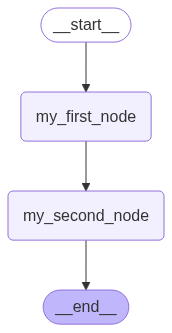

In [18]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
graph.invoke({"name":"Andronik", "my_input": "What can I help you with?"})

{'messages': 'Hello, Andronik. What can I help you with?',
 'name': 'Andronik',
 'my_input': 'What can I help you with?'}

### Step 2: Workflow

In [20]:
class State(TypedDict):
    messages: str

In [26]:
def to_upper(state: State) -> State:
    """Node 1 – make the string uppercase."""

    state["messages"] = state["messages"].upper()
    
    return {"messages": state["messages"]}

def reverse_text(state: State) -> State:
    """Node 2 – reverse the characters."""

    state["messages"] = state["messages"][::-1]
    
    return {"messages": state["messages"]}

def add_suffix(state: State) -> State:
    """Node 3 – add a friendly suffix and finish."""
    
    state["messages"] = state["messages"] + " 🤖"
    
    return {"messages": state["messages"]}

In [29]:
workflow = StateGraph(State)

workflow.add_node("uppercase", to_upper)
workflow.add_node("reverse",   reverse_text)
workflow.add_node("suffix",    add_suffix)

workflow.add_edge("uppercase", "reverse")
workflow.add_edge("reverse",   "suffix")
workflow.add_edge(START, "uppercase")
workflow.add_edge("suffix", END)

graph = workflow.compile()

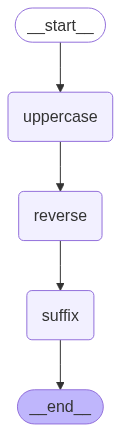

In [30]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
graph.invoke({"messages":"Andronik"})

{'messages': 'KINORDNA 🤖'}

### Step 3: Conditional Edges